In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.datasets import fetch_mldata

plt.gray()
%matplotlib inline

In [5]:
def sample_c(n):
    return np.random.multinomial(1, [0.1]*10, size=n)
def sample_z(*shape):
    return np.random.uniform(-1, 1.0, shape)

In [6]:
mnist = fetch_mldata('MNIST original')
x_data = mnist['data'] / 255.0
del mnist

In [7]:
def next_batch(n):
    return x_data[np.random.randint(0, len(x_data), size=n)]

In [87]:
def q_net(x, reuse=None):
    h = disc_net(x, reuse=reuse)
    with tf.variable_scope('q_net'):
        h = tf.layers.dense(h, 10, activation=tf.nn.softmax)
    return h
def generator(x, c, reuse=None):
    with tf.variable_scope('generator', reuse=reuse):
        h = tf.concat((x, c), axis=1)
        h = tf.layers.dense(h, 7*7*10, activation=tf.nn.relu)
        h = tf.layers.conv2d_transpose(tf.reshape(h, (tf.shape(h)[0], 7, 7, 10)), 64, (3,3), strides=(2,2), padding='same')
        h = tf.nn.relu(h)
        h = tf.layers.conv2d_transpose(h, 1, (3,3), strides=(2,2), padding='same')
    return tf.nn.sigmoid(tf.layers.flatten(h))
def disc_net(x, reuse=None):
    with tf.variable_scope('base_net', reuse=reuse):
        h = tf.layers.dense(x, 256, activation=tf.nn.relu)
    return h
def discriminator(x, reuse=None, reuse_n=None):
    h = disc_net(x, reuse=reuse_n)
    with tf.variable_scope('disc', reuse=reuse):
        h = tf.layers.dense(h, 1, activation=tf.nn.sigmoid)
    return h

In [88]:
# z_dim = 20 #works
z_dim = 20

In [89]:
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(11248123)
    Z_in = tf.placeholder(tf.float32, (None, z_dim))
    c_in = tf.placeholder(tf.float32, (None, 10))
    X_in = tf.placeholder(tf.float32, (None, 784))
    
    g_sample = generator(Z_in, c_in)
    d_fake = discriminator(g_sample)
    d_real = discriminator(X_in, True, True)
    qc_x = q_net(g_sample, True)
    
    d_loss = -tf.reduce_mean(tf.log(d_real + 1e-8) + tf.log(1-d_fake + 1e-8))
    g_loss = -tf.reduce_mean(tf.log(d_fake + 1e-8))
    
    q_ce = -tf.reduce_mean(tf.reduce_sum(tf.log(qc_x+1e-8) * c_in, axis=1))
    q_ent = -tf.reduce_mean(tf.reduce_sum(tf.log(c_in+1e-8) * c_in, axis=1))
    q_lb = q_ce + q_ent
    
    
    base_net_vars = g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'base_net')
    q_vars = g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') \
        + base_net_vars\
        + g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'q_net')
        
    d_step = tf.train.AdamOptimizer().minimize(
        d_loss, var_list=g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'disc') + base_net_vars)
    g_step = tf.train.AdamOptimizer().minimize(
        g_loss, var_list=g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator'))
    q_step = tf.train.AdamOptimizer().minimize(q_lb, var_list=q_vars)

In [90]:
try:
    while True:
        tf.get_default_session().close()
except: pass
sess = tf.InteractiveSession(graph=g)
sess.run(tf.global_variables_initializer())

In [91]:
bs = 32

In [92]:
dls = []
gls = []
save_every=500
N1 = 4
np.random.seed(10091883)
ref_c = sample_c(N1**2)
ref_z = sample_z(N1**2, z_dim)
for iteration in range(30000):
    if iteration % save_every == 0:
        ims = sess.run(g_sample, feed_dict={Z_in: ref_z, c_in: ref_c}).reshape(-1, 28, 28)
        fig = plt.figure(figsize=(16, 16))
        for i in range(N1*N1):
            ax = fig.add_subplot(N1, N1, i+1)
            ax.imshow(ims[i])
            ax.axis('off')
        fig.savefig('/Users/nikil/Downloads/out/%d.png'%(iteration//save_every))
        plt.close()
    xb = next_batch(bs) 
    z_ = sample_z(bs, z_dim)
    c_ = sample_c(bs)
    _, dl = sess.run([d_step, d_loss], feed_dict={X_in: xb, Z_in: z_, c_in: c_})
    _, gl = sess.run([g_step, g_loss], feed_dict={Z_in: z_, c_in: c_})
        
    dls.append(dl)
    gls.append(gl)
    sess.run([q_step], feed_dict={Z_in: z_, c_in: c_})
    if iteration % 500 == 0:
        print(f'Iter {iteration}, Discriminator loss: {dl:.5f}, Generator loss: {gl:.5f}')

Iter 0, Discriminator loss: 1.81829, Generator loss: 2.00867
Iter 500, Discriminator loss: 3.51298, Generator loss: 1.47524
Iter 1000, Discriminator loss: 0.82136, Generator loss: 1.98516
Iter 1500, Discriminator loss: 0.50467, Generator loss: 3.25985
Iter 2000, Discriminator loss: 0.44190, Generator loss: 2.03642
Iter 2500, Discriminator loss: 0.76943, Generator loss: 1.94563
Iter 3000, Discriminator loss: 0.68806, Generator loss: 2.34755
Iter 3500, Discriminator loss: 0.77061, Generator loss: 1.49869
Iter 4000, Discriminator loss: 0.78084, Generator loss: 2.00726
Iter 4500, Discriminator loss: 0.52659, Generator loss: 2.48002
Iter 5000, Discriminator loss: 0.75828, Generator loss: 1.61718
Iter 5500, Discriminator loss: 0.84327, Generator loss: 1.97028
Iter 6000, Discriminator loss: 0.78765, Generator loss: 1.91527
Iter 6500, Discriminator loss: 0.38960, Generator loss: 2.33411
Iter 7000, Discriminator loss: 0.62292, Generator loss: 2.46890
Iter 7500, Discriminator loss: 0.37495, Gene

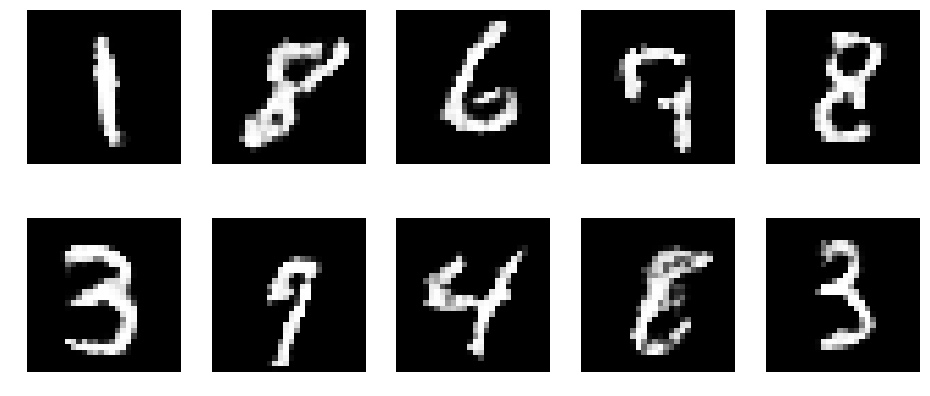

In [94]:
N1 = 4
plt.figure(figsize=(16, 7))
z_ = np.zeros((10, z_dim)) + sample_z(10, z_dim)
c_ = np.eye(10)
ims = sess.run(g_sample, feed_dict={Z_in: z_, c_in: c_}).reshape(-1, 28, 28)
for i in range(len(z_)):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(ims[i])
    ax.axis('off')